In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import kurtosis, skew
from scipy.fftpack import fft
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# **Data Preprocessing**

In [2]:
#Load synthetic dataset
data = pd.read_csv("gait_data.csv")
print(data)

# Normalize raw sensor data
scaler = StandardScaler()
data[['x', 'y', 'z']] = scaler.fit_transform(data[['x', 'y', 'z']])

# Segment data into fixed time windows
def segment_data(data, window_size=100, step=50):
    segments = []
    labels = []
    for i in range(0, len(data) - window_size, step):
        x = data['x'].values[i:i + window_size]
        y = data['y'].values[i:i + window_size]
        z = data['z'].values[i:i + window_size]
        employee_id = data['employee_id'][i]
        segments.append([x, y, z])
        labels.append(employee_id)
    return np.array(segments), np.array(labels)

segments, labels = segment_data(data)

       employee_id  timestamp         x         y         z
0                1          0  0.649017 -0.161680  0.624275
1                1          1  0.654635 -0.061521  0.600741
2                1          2  0.550970 -0.184606  0.601116
3                1          3  0.520910 -0.329592  0.475197
4                1          4  0.440485 -0.239547  0.679113
...            ...        ...       ...       ...       ...
29995           30        995 -0.478163  0.970016 -1.157560
29996           30        996 -0.441499  1.057518 -1.137099
29997           30        997 -0.486217  0.894571 -1.002298
29998           30        998 -0.471067  0.878125 -1.080155
29999           30        999 -0.349576  0.792291 -1.023309

[30000 rows x 5 columns]


# **Feature Extraction**

In [3]:
# Extract features from sensor data
def extract_features(segments):
    features = []
    for segment in segments:
        x, y, z = segment
        feature = []
        for axis in [x, y, z]:
            # Time-domain features
            feature.extend([np.mean(axis), np.std(axis), skew(axis), kurtosis(axis)])
            # Frequency-domain features
            fft_coeffs = fft(axis)
            feature.extend(np.abs(fft_coeffs[:10]))  # Top 10 FFT coefficients
        features.append(feature)
    return np.array(features)

features = extract_features(segments)

# **Model Training and Evaluation**

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.9417

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      0.75      0.86         4
           3       0.50      1.00      0.67         1
           4       1.00      0.89      0.94         9
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       0.75      1.00      0.86         3
          10       1.00      0.83      0.91         6
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         4
          13       1.00      0.75      0.86         4
          14       1.00      1.00      1.00         2
          15       0.80      0.80      0.80         5
          16       1.00      1.00      1.00         4
          17       0.83      1.00      0

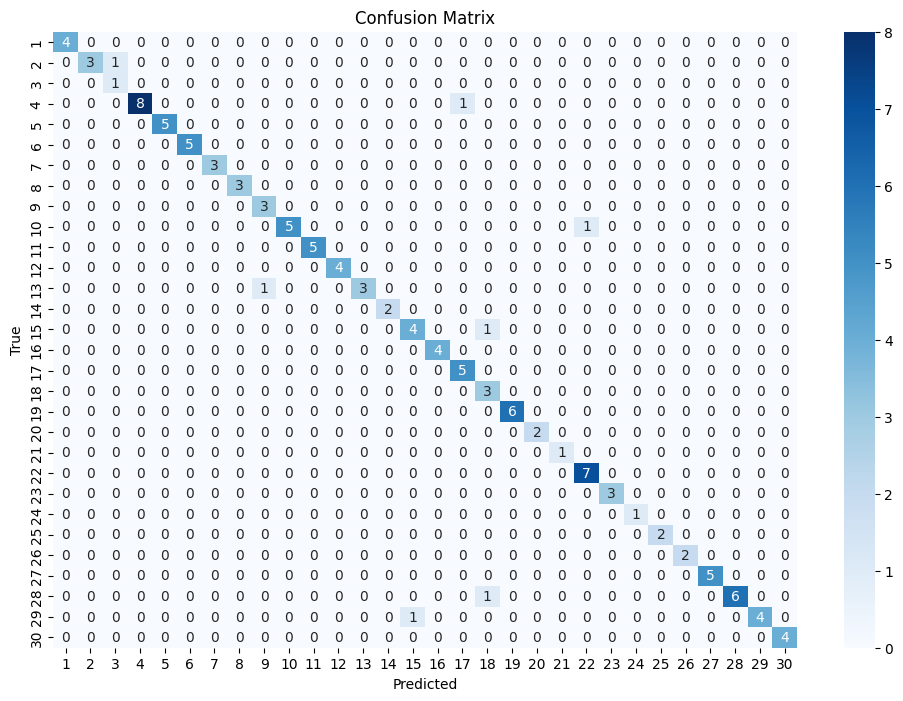

In [5]:
# Evaluate model performance
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, and F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **Real-Time Authentication**

In [6]:
# Real-time authentication
def authenticate(data_segment, model):
    # Preprocess new segment
    x, y, z = data_segment['x'].values, data_segment['y'].values, data_segment['z'].values
    segment = np.array([x, y, z])
    feature = extract_features([segment])[0]

    # Predict employee ID
    employee_id = model.predict([feature])[0]
    return employee_id

# Simulated incoming segment
new_segment = data.iloc[:100]
authenticated_id = authenticate(new_segment, clf)
print("Authenticated Employee ID:", authenticated_id)

Authenticated Employee ID: 1


# **Deployment**

Wrap the model into an API using Flask.

In [7]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/authenticate', methods=['POST'])
def authenticate_user():
    data = request.get_json()
    segment = pd.DataFrame(data)
    employee_id = authenticate(segment, clf, scaler)
    return jsonify({"employee_id": employee_id})

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
